In [63]:
# Imports
import pandas as pd
import math
import time 

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [64]:
# Constants
DATA_PATH = './data/'
DATASET_PATH = DATA_PATH + 'uci-data/'
MODELS_PATH = DATA_PATH + 'models/raw-models/'
FEATURES = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', "activity"]

BATCH_SIZE = 32
SAMPLE_SIZE = BATCH_SIZE * 150
EPOCHS = 10

In [65]:
'''
# Load the data
train_set = pd.read_csv(DATA_PATH + "self-calculated/raw-train-data.txt", sep='\s+', header=None)
test_set = pd.read_csv(DATA_PATH + "self-calculated/raw-test-data.txt", sep='\s+', header=None)

train_set.columns=FEATURES
test_set.columns=FEATURES
'''
# Loading functions
def load_data_frame(txt):
    return pd.read_csv(DATASET_PATH + txt + '.txt', header=None, sep='\s+')

complete_set = pd.read_csv(DATA_PATH + "self-calculated/raw-data.txt", sep='\s+', header=None)
complete_set.columns = FEATURES
train_set, test_set = train_test_split(complete_set, test_size=0.3)

activity_labels = load_data_frame('activity_labels')
activity_labels.columns = ['id', 'activity']

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/var/folders/lt/w0169b7x5ml3psz3nly9vj3m0000gn/T/ipykernel_47760/4052614162.py:1: SyntaxWarning: invalid escape sequence '\s'
  '''
/var/folders/lt/w0169b7x5ml3psz3nly9vj3m0000gn/T/ipykernel_47760/4052614162.py:11: SyntaxWarning: invalid escape sequence '\s'
  return pd.read_csv(DATASET_PATH + txt + '.txt', header=None, sep='\s+')
/var/folders/lt/w0169b7x5ml3psz3nly9vj3m0000gn/T/ipykernel_47760/4052614162.py:13: SyntaxWarning: invalid escape sequence '\s'
  complete_set = pd.read_csv(DATA_PATH + "self-calculated/raw-data.txt", sep='\s+', header=None)


In [66]:
# Creating model
device = None

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

class RawDataModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_module = nn.Sequential(
            nn.Conv1d(in_channels=len(FEATURES)-1, out_channels=256, kernel_size=1),
            nn.ReLU(), 
            nn.MaxPool1d(1),
            nn.BatchNorm1d(256),

            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=1),
            nn.ReLU(), 
            nn.MaxPool1d(1),
            nn.BatchNorm1d(128),

            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1),
            nn.ReLU(), 
            nn.MaxPool1d(1),
            nn.BatchNorm1d(128),

            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1),
            nn.ReLU(), 
            nn.MaxPool1d(1),
            nn.BatchNorm1d(64),
            
            nn.Flatten(),

            nn.Linear(64, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(),

            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(),

            nn.Linear(2048, 12),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.sequential_module(x)
    
model = RawDataModel().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [67]:
# Training and testing function
def train(dataloader, model, loss_fn, optimizer):
    # Get batch num
    num_batches = len(dataloader.dataset) / BATCH_SIZE
    i = 0

    # Set the model to train mode
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(-1)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        i += 1
        if batch % 50 == 0:
            print(f"loss: {loss.item()}, batch: {i} out of {math.ceil(num_batches)}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.unsqueeze(-1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            true_labels.extend(y.tolist())
            pred_labels.extend(pred.argmax(1).tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return (f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"), confusion_matrix(true_labels, pred_labels)

In [68]:
# Dataset preparation
class HAPTDataset(Dataset):
    def __init__(self, dataset, features, label):
        '''
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)[:SAMPLE_SIZE]
        self.labels = torch.tensor(dataset[label].values, dtype=torch.float32)[:SAMPLE_SIZE]
        '''
        max_size = len(dataset) - (len(dataset) % 32)
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)[:max_size]
        self.labels = torch.tensor(dataset[label].values, dtype=torch.float32)[:max_size]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
train_dataset = HAPTDataset(train_set, train_set.columns[:-1], 'activity')
test_dataset = HAPTDataset(test_set, test_set.columns[:-1], 'activity')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [69]:
perf_timer = time.perf_counter()
perf_acc, conf_matrix = None, None

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    perf_acc, conf_matrix = test(test_dataloader, model, loss_function)

print(perf_acc)
perf_timer = time.perf_counter() - perf_timer
print("Done!")

Epoch 1
-------------------------------
loss: 2.489284038543701, batch: 1 out of 17841
loss: 1.9744203090667725, batch: 51 out of 17841
loss: 1.8923699855804443, batch: 101 out of 17841
loss: 1.8975327014923096, batch: 151 out of 17841
loss: 1.8531423807144165, batch: 201 out of 17841
loss: 1.852437973022461, batch: 251 out of 17841
loss: 1.9806089401245117, batch: 301 out of 17841
loss: 1.9857035875320435, batch: 351 out of 17841
loss: 1.890402913093567, batch: 401 out of 17841
loss: 2.0115180015563965, batch: 451 out of 17841
loss: 2.0483484268188477, batch: 501 out of 17841
loss: 1.9865968227386475, batch: 551 out of 17841
loss: 1.9981210231781006, batch: 601 out of 17841
loss: 1.9270751476287842, batch: 651 out of 17841
loss: 1.945518136024475, batch: 701 out of 17841
loss: 1.751346230506897, batch: 751 out of 17841
loss: 1.8278002738952637, batch: 801 out of 17841
loss: 1.8669971227645874, batch: 851 out of 17841
loss: 1.9494134187698364, batch: 901 out of 17841
loss: 1.9009727239

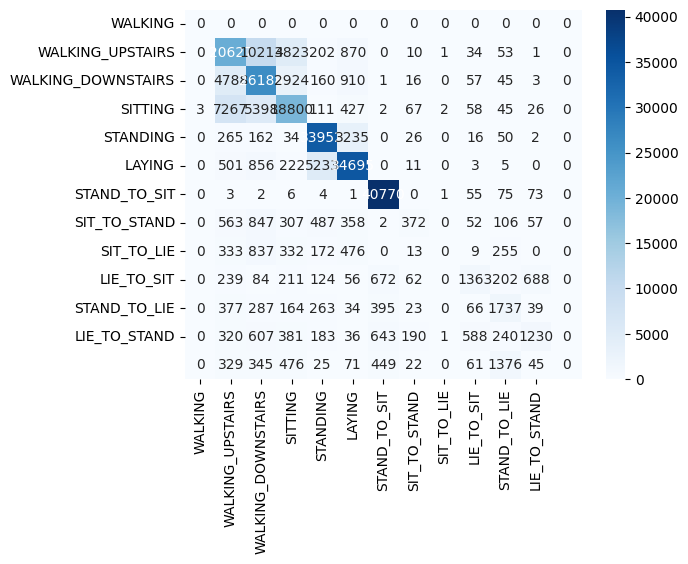

In [70]:
plot = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_labels.activity, yticklabels=activity_labels.activity)
            
model_name = "cnn_13"
if True:
    torch.save(model.state_dict(), MODELS_PATH + model_name + ".pth")


    with open(MODELS_PATH + model_name + ".txt", "w") as f:
        f.write("Epochs: {}\n".format(EPOCHS))
        f.write("Batch Size: {}\n".format(BATCH_SIZE))
        f.write("Sample Size: {}\n".format(SAMPLE_SIZE))
        f.write("Feature Set: {}\n".format(FEATURES))
        f.write("Model: {}\n".format(str(model)))
        f.write("Loss Function: {}\n".format("Cross Entropy Loss"))
        f.write("Optimizer: {}\n\n\n\n".format(str(optimizer)))
        f.write("Results: {}\n".format(perf_acc))
        f.write("Timer: {}s\n".format(round(perf_timer, 2)))
        
    plot.get_figure().savefig(MODELS_PATH + model_name + "_matrix.png")